In [3]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.io
import math
import scipy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from torch.autograd import Variable
import os
import csv

device = torch.device("cuda")
print(device)
torch.cuda.empty_cache()

cuda


In [16]:
# Random Field Generation Module
def cahn_hilliard_2d_pytorch(B,N):
    # --------------------
    # Simulation Parameters
    # --------------------
    DC1 = 2.0
    Nx = N      # number of points in x
    Ny = N      # number of points in y
    Lx = Nx * DC1 # physical size in x
    Ly = Ny * DC1 # physical size in y

    epsilon = 3.0      # interface width parameter (ε in PDE)
    dt = 10.0           # time step
    nSteps = 1000      # how many steps to simulate

    # For clarity, define epsilon^2 once:
    eps_sq = epsilon**2

    # --------------------
    # Construct wave numbers kx, ky
    #   PyTorch version of the standard "FFT frequencies"
    # --------------------
    # In Python, for Nx even: frequencies go [0..Nx/2-1, -Nx/2, -(Nx/2-1)..-1]
    kx = (2.0 * torch.pi / Lx * torch.cat((torch.arange(0,Nx//2),torch.arange(-Nx//2,0)),dim=0)).to(device)
    ky = (2.0 * torch.pi / Ly * torch.cat((torch.arange(0,Ny//2),torch.arange(-Ny//2,0)),dim=0)).to(device)

    # For consistency with c shape = [Ny, Nx], we might want to
    Kx, Ky = torch.meshgrid(kx, ky, indexing='ij')  # Kx_.shape = (Nx, Ny)
    Kx = Kx.T.to(device)  # shape (Ny, Nx)
    Ky = Ky.T.to(device)  # shape (Ny, Nx)
    K2 = Kx**2 + Ky**2  # shape (Ny, Nx)
    K2 = K2[None,:,:].repeat(B,1,1).to(device)

    # --------------------
    # Initial Condition: c in real space
    #   near zero + small random noise
    # --------------------
    c = (0.0 + 0.01*(2.0*torch.rand(B, Ny, Nx) - 1.0)).to(device)

    # Convert to Fourier space
    c_hat = torch.fft.fft2(c).to(device)

    # --------------------
    # Time-stepping loop
    # --------------------
    for step in range(nSteps):
        # Inverse FFT to get c in real space
        c_real = torch.fft.ifft2(c_hat).real

        # f'(c) = c^3 - c
        fprime = c_real**3 - c_real

        # Transform f'(c) to Fourier space
        fprime_hat = torch.fft.fft2(fprime)

        # Numerator and Denominator for the semi-implicit update
        # (Based on: c_hat_new = [c_hat + dt * (-k^2)*fprime_hat] / [1 + dt*ε²*k^4])
        numerator   = c_hat + dt * (-K2) * fprime_hat
        denominator = 1.0 + dt * eps_sq * (K2**2)

        c_hat_new = numerator / denominator

        # Update
        c_hat = c_hat_new

    # After time-stepping, transform back to real space
    c_final = torch.fft.ifft2(c_hat).real
    c_final[c_final>0.5] = 1.0
    c_final[c_final<=0.5] = 0.0

    return c_final

In [5]:
# FFT Homogenisation Module
class FFT_preparation():
    def __init__(self,N):
        super(FFT_preparation, self).__init__()
        # Material
        self.lam1 = 8.33
        self.mu1 = 3.86
        self.lam2 = 8.33*0.1
        self.mu2 = 3.86*0.1
        # Dimension of the plate
        self.Lx = 1
        self.Ly = 1
        # ID of each voxel element
        self.m = N
        self.n = N
        # Compute the Green function in the frequency domain
        # Matti, berbenni et.al- No-Need FFTshift and Ifftshift (Nyquist = 0)
        em = torch.pi * torch.cat([torch.arange(self.m//2, dtype=torch.float32),torch.arange(-self.m//2, 0, dtype=torch.float32)])/self.m
        en = torch.pi * torch.cat([torch.arange(self.n//2, dtype=torch.float32),torch.arange(-self.n//2, 0, dtype=torch.float32)])/self.n
        # Create a meshgrid
        ey, ex = torch.meshgrid(em, en, indexing='ij')
        # Calculate e1t and e2t
        self.e1t = ((self.m / self.Lx) * torch.sin(ey) * torch.cos(ex)).to(device)
        self.e2t = ((self.n / self.Ly) * torch.cos(ey) * torch.sin(ex)).to(device)
        self.e1to = self.e1t[None,:,:].to(device)
        self.e2to = self.e2t[None,:,:].to(device)
        self.cpx = 0
        self.cpy = 0
        # Referene properties
        self.Eigenp_FFT()
        # Constants in Green's function
        self.GreenFunction_Membrane()

    def forward(self,images):
        # Dimension of the plate
        self.INF = images.reshape(images.size(0), images.size(1)*images.size(2)).to(device)
        # ID of each voxel element
        self.Con_gp = self.Global_Constitute().to(device)
        eps1, sig1 = self.FFT_Homogenisation(torch.tensor([1.0,0.0,0.0]).to(device))
        eps2, sig2 = self.FFT_Homogenisation(torch.tensor([0.0,1.0,0.0]).to(device))
        eps3, sig3 = self.FFT_Homogenisation(torch.tensor([0.0,0.0,1.0]).to(device))
        self.eps1 = eps1
        D = self.homo_properties(sig1,sig2,sig3)
        return D

    def Eigenp_FFT(self):
        # Eigen functions
        Evlist_1 = self.Elastic_Model(self.lam1,self.mu1)
        Evlist_2 = self.Elastic_Model(self.lam2,self.mu2)
        # Find minimum and maximum eigenvalues
        Evmin = torch.max(torch.linalg.eigvals(Evlist_1).real)
        Evmax = torch.max(torch.linalg.eigvals(Evlist_2).real)
        # Compute lambda0 and mu0
        self.lambda0 = 0
        self.mu0 = (Evmin + Evmax) / 4

    def Elastic_Model(self,K,mu):
        # Elastic stiffness matrix (D_e)
        E = (9 * K * mu) / (3 * K + mu)
        nu = (3 * K - 2 * mu) / (2 * (3 * K + mu))
        D_e = (E/((1+nu)*(1-2*nu))) * torch.tensor([[1 - nu, nu, 0],
                [nu, 1 - nu, 0],
                [0, 0, (1 - 2 * nu) / 2]], dtype=torch.float64)
        return D_e

    def Global_Constitute(self):
        # Initial Stiffness matrix
        D_e1 = self.Elastic_Model(self.lam1,self.mu1).reshape(1, 1, 9)  # Reshape the stiffness matrix to [1, 1, 9]
        D_e2 = self.Elastic_Model(self.lam2,self.mu2).reshape(1, 1, 9)
        # Identify phases
        Phase1 = self.INF == 1  # Phase 1: Material
        # Create Phase tensor
        Phase = torch.zeros((self.INF.size(0), self.INF.size(1), 1), dtype=torch.float32)
        Phase[Phase1] = 1.0
        # Compute stiffness field
        Con_gp = Phase * D_e1 + (1.0-Phase) * D_e2
        return Con_gp

    def GreenFunction_Membrane(self):
        # Constants in Green's function
        c1 = 1 / (4 * self.mu0)
        c2 = (self.lambda0 + self.mu0) / (self.mu0 * (self.lambda0 + 2 * self.mu0))
        # Initialize Green function tensors
        # Compute the norm of each [e1, e2] pair
        E = torch.sqrt(self.e1t**2 + self.e2t**2)
        # Compute terms for Green's function components
        e1_squared = self.e1t**2
        e2_squared = self.e2t**2
        e1_e2 = self.e1t * self.e2t
        e1_fourth = e1_squared**2
        e2_fourth = e2_squared**2
        # Calculate Green's function components
        self.T11 = c1 / E**2 * (4 * e1_squared) - c2 * e1_fourth / E**4
        self.T12 = -c2 * e1_squared * e2_squared / E**4
        self.T13 = c1 / E**2 * (2 * e1_e2) - c2 * e1_squared * e1_e2 / E**4
        self.T22 = c1 / E**2 * (4 * e2_squared) - c2 * e2_fourth / E**4
        self.T23 = c1 / E**2 * (2 * e1_e2) - c2 * e2_squared * e1_e2 / E**4
        self.T33 = c1 / E**2 * (e1_squared + e2_squared) - c2 * e1_squared * e2_squared / E**4
        # Modify the Green function tensor according to Voigt notation
        self.T13 *= 2
        self.T23 *= 2
        self.T33 *= 4
        # Complete the symmetric part
        self.T21 = self.T12.clone()
        self.T31 = self.T13.clone()
        self.T32 = self.T23.clone()
        # Modify the Green tensor at zero frequency
        cpx = 0
        cpy = 0
        self.T11[cpx, cpy] = 0
        self.T12[cpx, cpy] = 0
        self.T13[cpx, cpy] = 0
        self.T21[cpx, cpy] = 0
        self.T22[cpx, cpy] = 0
        self.T23[cpx, cpy] = 0
        self.T31[cpx, cpy] = 0
        self.T32[cpx, cpy] = 0
        self.T33[cpx, cpy] = 0

    def FFT_Homogenisation(self, Strain):

        K_e = self.Con_gp.to(device)

        batch = K_e.shape[0]
        m, n = self.m, self.n

        # Initialize strain fields
        e11 = Strain[0].expand(batch, m, n).clone().to(device)
        e22 = Strain[1].expand(batch, m, n).clone().to(device)
        e12 = Strain[2].expand(batch, m, n).clone().to(device)

        mn = m * n

        # Flatten strain fields
        e11 = e11.reshape(batch, mn).to(device)
        e22 = e22.reshape(batch, mn).to(device)
        e12 = e12.reshape(batch, mn).to(device)

        # Calculate stress fields
        s11 = (K_e[..., 0] * e11 + K_e[..., 1] * e22 + K_e[..., 2] * e12).to(device)
        s22 = (K_e[..., 3] * e11 + K_e[..., 4] * e22 + K_e[..., 5] * e12).to(device)
        s12 = (K_e[..., 6] * e11 + K_e[..., 7] * e22 + K_e[..., 8] * e12).to(device)

        # Reshape back to 2D
        e11 = e11.reshape(batch, m, n).to(device)
        e22 = e22.reshape(batch, m, n).to(device)
        e12 = e12.reshape(batch, m, n).to(device)
        s11 = s11.reshape(batch, m, n).to(device)
        s22 = s22.reshape(batch, m, n).to(device)
        s12 = s12.reshape(batch, m, n).to(device)

        # FFT on the strain fields
        e11fft = torch.fft.fft2(e11, dim=(-2, -1)).to(device)
        e22fft = torch.fft.fft2(e22, dim=(-2, -1)).to(device)
        e12fft = torch.fft.fft2(e12, dim=(-2, -1)).to(device)

        # Iterative FFT homogenisation
        iter = 0
        ec = 1
        # while ec > 1e-5:
        for q in range(300):
            iter += 1

            # FFT on the stress fields
            s11fft = torch.fft.fft2(s11, dim=(-2, -1))
            s22fft = torch.fft.fft2(s22, dim=(-2, -1))
            s12fft = torch.fft.fft2(s12, dim=(-2, -1))

            # Update the strain
            e11fft = (e11fft - (self.T11 * s11fft + self.T12 * s22fft + self.T13 * s12fft))
            e22fft = (e22fft - (self.T21 * s11fft + self.T22 * s22fft + self.T23 * s12fft))
            e12fft = (e12fft - (self.T31 * s11fft + self.T32 * s22fft + self.T33 * s12fft))

            # Modify the strain at zero frequency
            e11fft[:, self.cpx, self.cpy] = Strain[0] * mn
            e22fft[:, self.cpx, self.cpy] = Strain[1] * mn
            e12fft[:, self.cpx, self.cpy] = Strain[2] * mn

            # IFFT on the strain
            e11 = torch.fft.ifft2(e11fft, dim=(-2, -1)).real
            e22 = torch.fft.ifft2(e22fft, dim=(-2, -1)).real
            e12 = torch.fft.ifft2(e12fft, dim=(-2, -1)).real

            # Flatten strain fields
            e11 = e11.reshape(batch, mn)
            e22 = e22.reshape(batch, mn)
            e12 = e12.reshape(batch, mn)

            # Calculate stress fields
            s11 = (K_e[..., 0] * e11 + K_e[..., 1] * e22 + K_e[..., 2] * e12)
            s22 = (K_e[..., 3] * e11 + K_e[..., 4] * e22 + K_e[..., 5] * e12)
            s12 = (K_e[..., 6] * e11 + K_e[..., 7] * e22 + K_e[..., 8] * e12)

            # Reshape back to 2D
            e11 = e11.reshape(batch, m, n)
            e22 = e22.reshape(batch, m, n)
            e12 = e12.reshape(batch, m, n)
            s11 = s11.reshape(batch, m, n)
            s22 = s22.reshape(batch, m, n)
            s12 = s12.reshape(batch, m, n)

        # Compute the average/homogenized stress (real part)
        e11 = e11[:,None,:,:].real.to(device)
        e22 = e22[:,None,:,:].real.to(device)
        e12 = e12[:,None,:,:].real.to(device)
        s11 = s11[:,None,:,:].real.to(device)
        s22 = s22[:,None,:,:].real.to(device)
        s12 = s12[:,None,:,:].real.to(device)

        return torch.cat((e11, e22, e12),dim=1), torch.cat((s11, s22, s12),dim=1)

    def homo_properties(self,sig1,sig2,sig3):
            # Homogenisation
            p11 = torch.mean(sig1[:,0,:,:], dim=(-2, -1))
            p21 = torch.mean(sig1[:,1,:,:], dim=(-2, -1))
            p31 = torch.mean(sig1[:,2,:,:], dim=(-2, -1))

            p12 = torch.mean(sig2[:,0,:,:], dim=(-2, -1))
            p22 = torch.mean(sig2[:,1,:,:], dim=(-2, -1))
            p32 = torch.mean(sig2[:,2,:,:], dim=(-2, -1))

            p13 = torch.mean(sig3[:,0,:,:], dim=(-2, -1))
            p23 = torch.mean(sig3[:,1,:,:], dim=(-2, -1))
            p33 = torch.mean(sig3[:,2,:,:], dim=(-2, -1))

            homo_stress = torch.stack([
                torch.stack([p11, p12, p13], dim=1),
                torch.stack([p21, p22, p23], dim=1),
                torch.stack([p31, p32, p33], dim=1)
            ], dim=1)
            return homo_stress

In [17]:
B = 100 # Batch size
N = 128 # Resolution
Cp = cahn_hilliard_2d_pytorch(B,N)
Module = FFT_preparation(N)

In [20]:
D = Module.forward(Cp)
print(D[0])

tensor([[3.4900, 1.2175, 0.3007],
        [1.2175, 2.8844, 0.1636],
        [0.3007, 0.1636, 0.8846]], device='cuda:0', dtype=torch.float64)


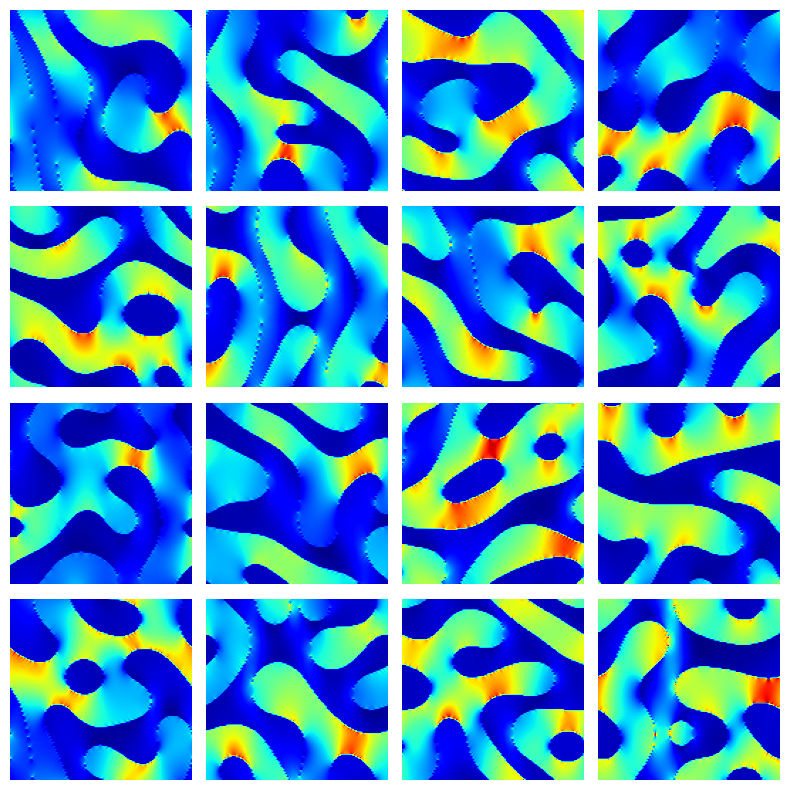

In [19]:
fig = plt.figure(figsize=(8, 8))
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    datap = Module.eps1[i,0]
    ax.imshow(datap.cpu(), extent=[0, 1, 0, 1],cmap='jet')
    ax.axis('off')
plt.tight_layout()
plt.show()